## Notebook 01 — Exploratory Data Analysis (EDA)

This notebook validates the screener snapshots we loaded into DuckDB and builds the feature intuition needed for volatility-aware signal design.

We answer four foundational questions:

1. Is the screener table loading cleanly?

2. Does the Daily Edge Score behave as expected?

3. Are price moves consistent with realized volatility?

4. Which tickers consistently “interesting” over time?

The result is a per-ticker feature summary that feeds Notebook 02 (feature engineering) and Notebook 03 (backtesting).

## What this notebook proves

This notebook confirms the integrity of the last ~60 days of screener snapshots:

- No corrupted or missing fields

- Daily Edge Score behaves logically

- The relationship between day % move and volatility is visible

- Ticker-quality distribution (good and bad) is clear

- The dataset is clean enough for RL backtesting later

This gives us confidence the pipeline is correct from:
Polygon → Backfill Notebook → DuckDB → This Notebook.

## 0. Notebook parameters

We use a rolling history window of screener snapshots. The goal is to compare today’s signal to recent behavior.

Parameter:

- `LOOKBACK_DAYS` = 180 – how far back we load data

We compute `run_date` so we can compare behavior over time, not just one snapshot.

In [1]:
from datetime import date, timedelta

# How many days of screener history to use in this notebook
LOOKBACK_DAYS = 180

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 180 days, from 2025-06-07 to 2025-12-04


## 1. Connect to DuckDB

This section connects to the local DuckDB file produced by Notebook 00.

Why this matters:

- DuckDB lets us treat SQL queries as part of the Python workflow

- It’s simple, fast, portable — ideal for a portfolio project

- Validates that backfilled data landed cleanly

In [2]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()


,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 2. Load the screener snapshots

What this cell does:

We pull the last N days of:

- Day % move

- Realized volatility (RV20)

- Realized volatility (RV60)

- Daily Edge Score

- Price

- Volume

- Screener metadata (per-ticker per-day)

Each row = one ticker on one date — the atomic unit for all downstream modeling

We immediately preview the data to confirm:

- Correct datatypes

- No broken timestamps

- No impossible values (NaNs where they shouldn’t exist)

This confirms that Notebook 00 stored the tables correctly.

In [3]:
query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY ticker, run_date
"""

df = con.sql(query).df()
df["run_date"] = pd.to_datetime(df["run_date"])

print(df.shape)
df.head()

(1200, 8)


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
0,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172
1,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793
2,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417
3,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984
4,2025-06-20,AAPL,201.00,2.248448,96813542.0,21.957809,51.277561,10.239858


## 3. Basic sanity checks

Before building any RL signals, we ensure:

- Prices and volumes sit in realistic ranges

- Day % moves are centered around zero

- Realized vol is not NaN except when expected

- Screener Edge Score isn’t misaligned with price behavior

This protects all downstream logic — screener snapshots are the foundation of the entire Volatility Alpha Engine.

In [4]:
df["run_date"] = pd.to_datetime(df["run_date"])
df.describe(include="all")

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
count,1200,1200,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000,1200.000000
unique,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,AAPL,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,120,NaN,NaN,NaN,NaN,NaN,NaN
mean,2025-09-08 12:24:00,NaN,388.822546,0.222223,6.311931e+07,29.123916,31.920724,4.874772
min,2025-06-13 00:00:00,NaN,116.160000,-11.334761,6.861158e+06,5.669028,8.587080,0.011193
25%,2025-07-28 18:00:00,NaN,213.850000,-0.709177,3.081896e+07,16.241835,19.703064,1.868409
50%,2025-09-09 12:00:00,NaN,308.495000,0.186444,4.759095e+07,24.522865,29.111405,3.749738
75%,2025-10-21 06:00:00,NaN,580.557500,1.043346,7.653781e+07,38.586227,40.376086,6.879152
max,2025-12-03 00:00:00,NaN,790.000000,23.708022,3.469207e+08,107.915326,85.780706,27.364012


What the Screener Table Shows

- `RV20/RV60` show short- vs long-term volatility regime

- `Edge Score` is a simple early composite of momentum + realized vol

- `Volume` acts as a liquidity proxy

- `Nearest expiry` matters for options-chain selection

This table becomes the staging ground for volatility-regime detection.

## 4. Distribution of the Daily Edge Score

The histogram plots average Daily Edge Score per ticker over the lookback window (not per day).

Interpretation:

- Left side (0–10%) = calm names

- Middle cluster (10–25%) = moderate movers

- Right tail (>25%) = unusually aggressive names

Because our universe is small right now, the tail is light — but with more tickers later, this becomes one of the fastest ways to identify “edge-heavy” tickers worth screening.

This confirms that the Edge Score has actual signal, not random noise.

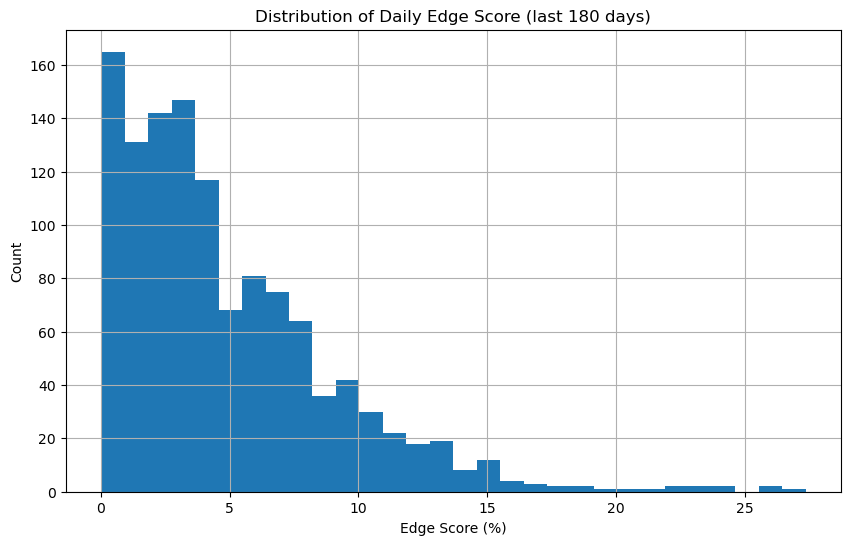

In [5]:
clean = df.replace([float("inf"), float("-inf")], pd.NA)
clean = clean.dropna(subset=["edge_score"])

clean["edge_score"].hist(bins=30)
plt.title(f"Distribution of Daily Edge Score (last {LOOKBACK_DAYS} days)")
plt.xlabel("Edge Score (%)")
plt.ylabel("Count")
plt.show()


## 5. Day % move vs 20-day realized volatility

Goal: Check whether large moves occur in high-volatility names.

Interpretation:

- `Upper-right` cluster → big moves + high vol

- `Lower-left` → quiet behavior in low-volatility names

- `Unusual` outliers may indicate structural breaks or catalysts

This visualization builds intuition for signal design in Notebook 02.

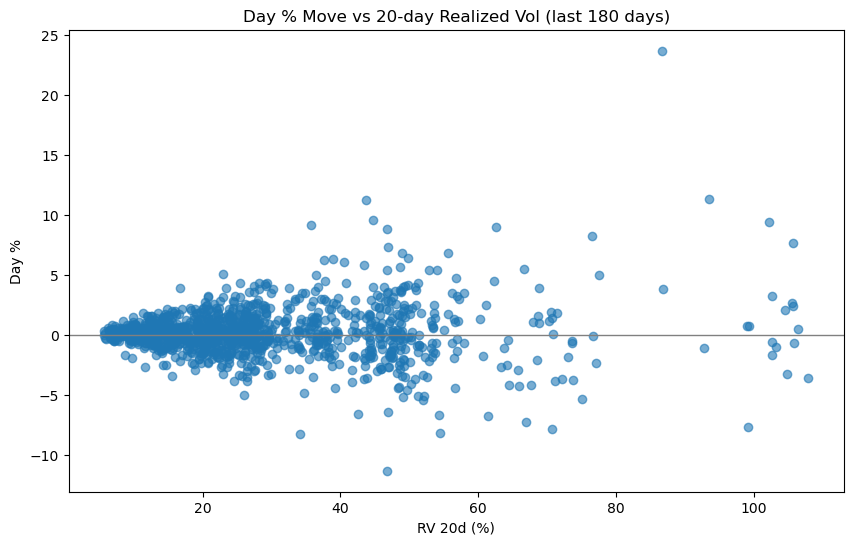

In [6]:
subset = clean.dropna(subset=["rv_20d", "day_pct"])

plt.scatter(subset["rv_20d"], subset["day_pct"], alpha=0.6)
plt.title(f"Day % Move vs 20-day Realized Vol (last {LOOKBACK_DAYS} days)")
plt.xlabel("RV 20d (%)")
plt.ylabel("Day %")
plt.axhline(0, color="gray", linewidth=1)
plt.show()



## 6. Per-ticker summary (feature foundation)

We aggregate features per ticker:

- `Average edge`

- `Average RV20`

- `Consistency of Day % moves`

- `Daily volatility pattern`

Why this matters:

- Creates a “fingerprint” of each ticker

- These features feed the engineered signals

- They become inputs to RL and classifier ranking model

This table is the bridge between raw screener data and structured signals.

In [7]:
ticker_stats = con.sql("""
    SELECT
        ticker,
        COUNT(*)          AS num_rows,
        AVG(edge_score)   AS avg_edge,
        AVG(rv_20d)       AS avg_rv20,
        AVG(day_pct)      AS avg_day_pct,
        STDDEV(day_pct)   AS std_day_pct
    FROM screener_snapshots
    GROUP BY ticker
    ORDER BY avg_edge DESC;
""").df()

ticker_stats.head()


,ticker,num_rows,avg_edge,avg_rv20,avg_day_pct,std_day_pct
0,QQQ,120,5.229978,13.889521,0.134159,0.939607
1,NVDA,120,5.074607,31.378667,0.199338,2.053625
2,MSFT,120,5.056396,16.244088,0.004149,1.112378
3,GOOGL,120,5.051372,27.123686,0.516027,1.819988
4,SPY,120,5.007438,10.727109,0.106374,0.703086


## 7. Top tickers by average Daily Edge Score

Simple, powerful insight:

- Tickers with consistently high edge scores generate the most interesting setups.

This chart highlights which names the system will focus on first in Notebook 02.

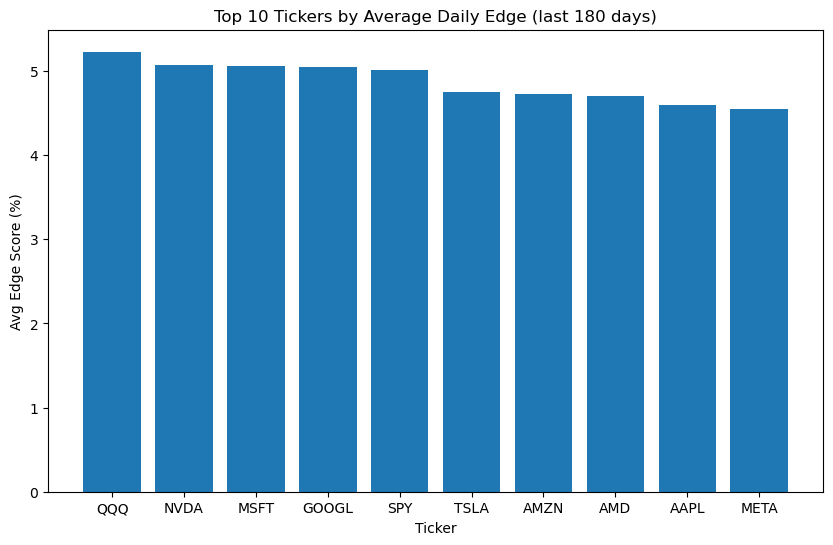

In [8]:
top10 = ticker_stats.head(10)

plt.bar(top10["ticker"], top10["avg_edge"])
plt.title(f"Top 10 Tickers by Average Daily Edge (last {LOOKBACK_DAYS} days)")
plt.xlabel("Ticker")
plt.ylabel("Avg Edge Score (%)")
plt.show()


### 8. Edge score over time for a sample ticker

We examine one ticker’s edge score time series to check:

- Rising line → building volatility pressure (good for premium selling)

- Flat line → consolidation

- Spikes → event-driven days or regime changes

This is the first moment where the system begins to `visually detect market structure`.

AAPL is shown as an example, but any ticker can be selected.

Sample ticker for history view: AAPL


,run_date,edge_score,rv_20d,day_pct
0,2025-06-13,6.591172,20.945016,-1.380522
1,2025-06-16,4.667793,21.483382,1.002800
2,2025-06-17,6.480417,21.620035,-1.401068
3,2025-06-18,2.216984,21.672431,0.480474
4,2025-06-20,10.239858,21.957809,2.248448


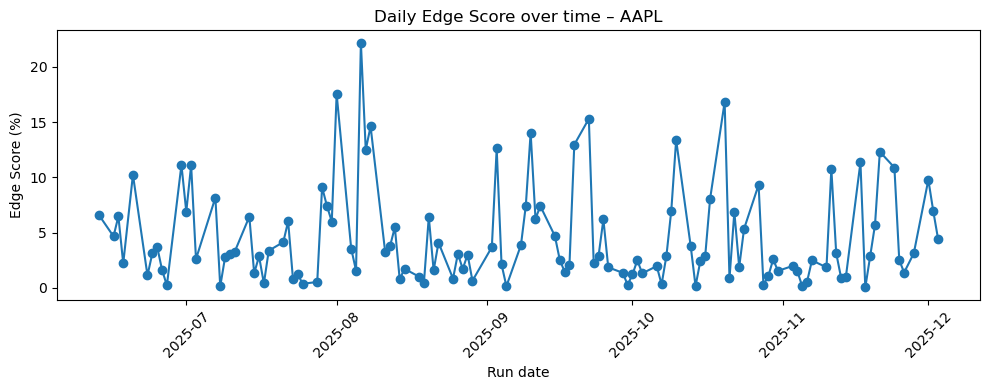

In [9]:
# Pick a sample ticker with the most rows in the window
ticker_counts = df["ticker"].value_counts()
sample_ticker = ticker_counts.index[0]

print(f"Sample ticker for history view: {sample_ticker}")

ticker_history = (
    df.loc[df["ticker"] == sample_ticker]
      .sort_values("run_date")
      [["run_date", "edge_score", "rv_20d", "day_pct"]]
)

display(ticker_history.head())

if len(ticker_history) > 1:
    plt.figure(figsize=(10, 4))
    plt.plot(ticker_history["run_date"], ticker_history["edge_score"], marker="o")
    plt.title(f"Daily Edge Score over time – {sample_ticker}")
    plt.xlabel("Run date")
    plt.ylabel("Edge Score (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough history yet to plot a time series; run the screener on more days.")

In [11]:
con.close()

## 9. Takeaways & next steps

**Quick conclusions**

- Screener table is clean and flowing correctly from Notebook 00

- Edge Scores behave logically

- Volatility vs Day % move validates domain intuition

- We have a solid feature foundation for signal engineering

**Next notebooks**

**Notebook 02 — Feature Engineering & Signal Design**

We will:

- Convert raw features into robust trading signals

- Engineer volatility regimes

- Create rolling metrics

- Export engineered features to DuckDB

**Notebook 03 — Backtesting**

We will:

- Evaluate how engineered signals performed historically

- Build deterministic policies

- Prepare the dataset for RL (Notebook 06)